In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Sun Jan 21 21:07:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_encoder import Encoder
from model.latent.binary_vqvae_latent import Latent
from model.decoder.dalle_decoder import Decoder
from model.no_module import NoModule

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.n_latents = 8
hp.z_dim = 512
print(hp.z_dim)

512


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), NoModule(**hp), Latent(**hp), NoModule(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 18.6689453125
encoder.encoder 18.6689453125
prior 0.0
latent 200.0625
latent.bottles 0.0
latent.linear 200.0625
quantizer 0.0
decoder 9.954113006591797
decoder.decoder 9.954113006591797
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.21-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 21819, model_list, optimizer_list)

total 702720
-rw-rw-r-- 1 scpark scpark      6966  1월 21 21:07 events.out.tfevents.1705838704.GPUSVR11
-rw-rw-r-- 1 scpark scpark 719567239  1월 21 21:05 save_0
-rw-rw-r-- 1 scpark scpark       661  1월 21 21:00 events.out.tfevents.1705838322.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

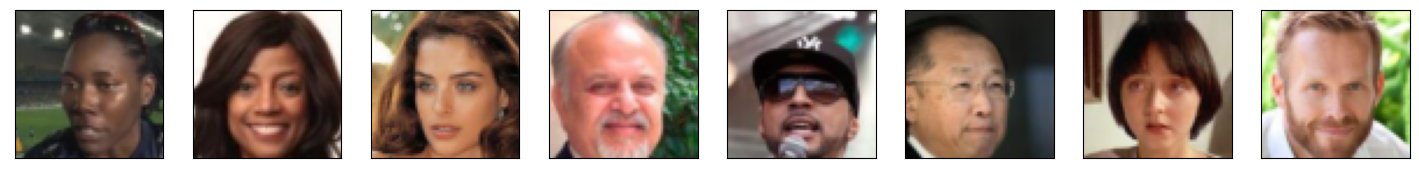

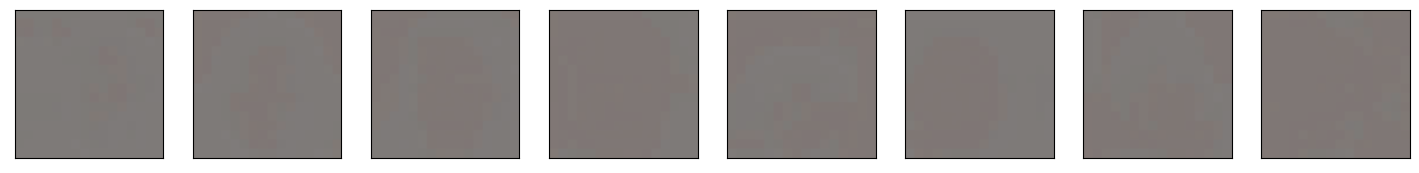

1
commit_loss 0.03170626237988472
recon_loss 0.08240532875061035
2
commit_loss 0.041111014783382416
recon_loss 0.1344243735074997
3
commit_loss 0.015372189693152905
recon_loss 0.13709059357643127
4
commit_loss 0.03337335214018822
recon_loss 0.11194639652967453
5
commit_loss 0.03349817171692848
recon_loss 0.10353322327136993
6
commit_loss 0.028345657512545586
recon_loss 0.11012893915176392
7
commit_loss 0.039000656455755234
recon_loss 0.09991073608398438
8
commit_loss 0.0781838595867157
recon_loss 0.08624198287725449
9
commit_loss 0.14102976024150848
recon_loss 0.09330277889966965
10
commit_loss 0.1827969253063202
recon_loss 0.11134485900402069
11
commit_loss 0.14312583208084106
recon_loss 0.12460759282112122
12
commit_loss 0.07847189903259277
recon_loss 0.14703050255775452
13
commit_loss 0.04913368448615074
recon_loss 0.1443670243024826
14
commit_loss 0.05157836526632309
recon_loss 0.11175864934921265
15
commit_loss 0.06287713348865509
recon_loss 0.09568806737661362
16
commit_loss 0.07

commit_loss 0.05072624981403351
recon_loss 0.020581984892487526
125
commit_loss 0.05734318122267723
recon_loss 0.02140199765563011
126
commit_loss 0.056070249527692795
recon_loss 0.02029772847890854
127
commit_loss 0.06028478965163231
recon_loss 0.022473370656371117
128
commit_loss 0.05978832766413689
recon_loss 0.020790114998817444
129
commit_loss 0.07021922618150711
recon_loss 0.019775420427322388
130
commit_loss 0.0547432005405426
recon_loss 0.01928018033504486
131
commit_loss 0.05903679132461548
recon_loss 0.020052116364240646
132
commit_loss 0.057174962013959885
recon_loss 0.021198377013206482
133
commit_loss 0.0516820102930069
recon_loss 0.02010330557823181
134
commit_loss 0.04959744215011597
recon_loss 0.020400598645210266
135
commit_loss 0.04768259823322296
recon_loss 0.02104555070400238
136
commit_loss 0.04388882592320442
recon_loss 0.02215268835425377
137
commit_loss 0.0415165051817894
recon_loss 0.02105128765106201
138
commit_loss 0.037094440311193466
recon_loss 0.0189354009

commit_loss 0.036595698446035385
recon_loss 0.014800403267145157
246
commit_loss 0.03689834102988243
recon_loss 0.015839118510484695
247
commit_loss 0.03853042423725128
recon_loss 0.015915673226118088
248
commit_loss 0.03404496982693672
recon_loss 0.015293094329535961
249
commit_loss 0.02933059260249138
recon_loss 0.01426415704190731
250
commit_loss 0.02846548520028591
recon_loss 0.01397712342441082
251
commit_loss 0.03483864665031433
recon_loss 0.01573900505900383
252
commit_loss 0.031790841370821
recon_loss 0.014888538047671318
253
commit_loss 0.034155555069446564
recon_loss 0.015141433104872704
254
commit_loss 0.032981231808662415
recon_loss 0.014757238328456879
255
commit_loss 0.03208842873573303
recon_loss 0.013798854313790798
256
commit_loss 0.0367157943546772
recon_loss 0.01457283180207014
257
commit_loss 0.03738471120595932
recon_loss 0.014893907122313976
258
commit_loss 0.03896351531147957
recon_loss 0.015027297660708427
259
commit_loss 0.038149673491716385
recon_loss 0.014048

commit_loss 0.03512108325958252
recon_loss 0.01359524019062519
367
commit_loss 0.03825412690639496
recon_loss 0.01463577151298523
368
commit_loss 0.03817390277981758
recon_loss 0.012885009869933128
369
commit_loss 0.03735789284110069
recon_loss 0.014620814472436905
370
commit_loss 0.03290201351046562
recon_loss 0.012620802968740463
371
commit_loss 0.038520634174346924
recon_loss 0.014194872230291367
372
commit_loss 0.043733593076467514
recon_loss 0.014015145599842072
373
commit_loss 0.042330700904130936
recon_loss 0.013398688286542892
374
commit_loss 0.04611368849873543
recon_loss 0.014803871512413025
375
commit_loss 0.04437266290187836
recon_loss 0.014103422872722149
376
commit_loss 0.03741728886961937
recon_loss 0.012643454596400261
377
commit_loss 0.041509296745061874
recon_loss 0.013711810111999512
378
commit_loss 0.035477928817272186
recon_loss 0.0124244075268507
379
commit_loss 0.03693309426307678
recon_loss 0.013081390410661697
380
commit_loss 0.037856586277484894
recon_loss 0.0

commit_loss 0.03177354484796524
recon_loss 0.012325270101428032
488
commit_loss 0.03242287412285805
recon_loss 0.012665694579482079
489
commit_loss 0.03369438275694847
recon_loss 0.012460468336939812
490
commit_loss 0.03657962754368782
recon_loss 0.01228272169828415
491
commit_loss 0.03887195140123367
recon_loss 0.012750320136547089
492
commit_loss 0.03448813036084175
recon_loss 0.011823801323771477
493
commit_loss 0.034879546612501144
recon_loss 0.012273035943508148
494
commit_loss 0.03687237203121185
recon_loss 0.012732530012726784
495
commit_loss 0.03883765637874603
recon_loss 0.01290055550634861
496
commit_loss 0.037347957491874695
recon_loss 0.012461155652999878
497
commit_loss 0.03645242378115654
recon_loss 0.012004224583506584
498
commit_loss 0.03611370176076889
recon_loss 0.012263680808246136
499
commit_loss 0.03977477177977562
recon_loss 0.013252155855298042
500
commit_loss 0.03589621186256409
recon_loss 0.012645157985389233
501
commit_loss 0.03194577991962433
recon_loss 0.012

commit_loss 0.02768201008439064
recon_loss 0.010175942443311214
609
commit_loss 0.028593087568879128
recon_loss 0.010412908159196377
610
commit_loss 0.02599085494875908
recon_loss 0.010403169319033623
611
commit_loss 0.026372985914349556
recon_loss 0.010585743002593517
612
commit_loss 0.025631368160247803
recon_loss 0.010696410201489925
613
commit_loss 0.025973699986934662
recon_loss 0.01002708449959755
614
commit_loss 0.024804415181279182
recon_loss 0.009726382791996002
615
commit_loss 0.02935645915567875
recon_loss 0.010678457096219063
616
commit_loss 0.023483091965317726
recon_loss 0.00998752936720848
617
commit_loss 0.024976830929517746
recon_loss 0.009806732647120953
618
commit_loss 0.02650667354464531
recon_loss 0.0099155493080616
619
commit_loss 0.028930531814694405
recon_loss 0.010433977469801903
620
commit_loss 0.024919871240854263
recon_loss 0.010644851252436638
621
commit_loss 0.022857025265693665
recon_loss 0.009182311594486237
622
commit_loss 0.02472745068371296
recon_loss

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            def get_entropy(zi):
                # (N, L)
                zi_onehot = F.one_hot(zi, num_classes=2 ** hp.n_latents)
                # (L)
                probs = zi_onehot.sum(dim=0) / len(zi_onehot)
                entropy = torch.sum(-probs * (torch.log(torch.clamp(probs, 1e-8)) - np.log(2)))
                return entropy

            entropy = get_entropy(data['zi']).item()
            writer.add_scalar('entropy', entropy, step)

        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')